## Analysis of non-player characters (NPCs) in World of Warcraft (WoW)

[World of Warcraft (WoW)](https://en.wikipedia.org/wiki/World_of_Warcraft) is a popular online game originally published in 2004 by Blizzard Entertainment. The game has maintained its popularity over 13 years, with many updates to add new content. The game world is massive and contains many non-player characters (NPCs) with a variety of character statistics. This notebook shows how to explore the statistics of the game-world by scraping NPC data from a [Wikia](http://wowwiki.wikia.com/) maintained by fans of the game.

In [27]:
import re
from lxml import etree
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns

### Scrape data
The file `wowwiki_pages_current.xml` is a [database dump](http://wowwiki.wikia.com/wiki/Special:Statistics) of the WoW Wikia, containing the current version of every page on the Wikia. This amounts to ~500 MB of uncompressed text! To process this, we will use the [`lxml` library](http://lxml.de/). A [typical page we are interested in](http://wowwiki.wikia.com/wiki/Rat) looks something like this:

```xml
<page>
  <title>Rat</title>
  <ns>0</ns>
  <id>15369</id>
  <sha1>1q38rt4376m9s74uwwslwuea2yy16or</sha1>
  <revision>
    <id>2594586</id>
    <timestamp>2012-08-25T17:06:39Z</timestamp>
    <contributor>
      <username>MarkvA</username>
      <id>1171508</id>
    </contributor>
    <minor />
    <comment>adding ID to infobox, replaced: ...snip...</comment>
    <text xml:space="preserve" bytes="1491">{{npcbox
    |name=Rat|id=4075
        |image=Rat.png
        |level=1
        |race=Rat
        |creature=Critter
        |faction=Combat
        |aggro={{aggro|0|0}}
    |health=8
        |location=All around [[Azeroth (world)|Azeroth]]
}}

'''Rats''' are small [[critter]]s, found in many places, including [[Booty Bay]], [[The Barrens]], and the [[Deeprun Tram]]

....snip...
    </text>
  </revision>
</page>
```

We can see that the information we care about is inside of a `<text>` element, contained in an `npcbox`, following the pattern of `attribute=value`. In this case, `name=Rat`, `level=1`, `health=8`.

Because the file is pretty large, we will use the [`lxml.etree.iterparse()` method](http://lxml.de/parsing.html#iterparse-and-iterwalk) to examine each individual page **as it is parsed**, extracting relevant character information if it is present, and discarding each element when we are done with it (to save memory). Our strategy will be to process any `<text>` element we come across using the [regular expressions library](https://docs.python.org/3/library/re.html) ([regular expressions](https://en.wikipedia.org/wiki/Regular_expression) are a powerful tool for processing textual data).

In [25]:
MAXPRINT = 100 
MAXPROCESS = 1e7
numprocessed = 0
names = []
levels = []
healths = []
itertree = etree.iterparse('wowwiki_pages_current.xml')
for event, element in itertree:
    if numprocessed > MAXPROCESS:
        raise Exception('Maximum number of records processed')
        break
    numprocessed += 1
    
    # if we are currently looking at the text of an article **and** there's a health value, let's process it
    if element.tag.endswith('text') and element.text and 'health' in element.text:
        # this set of regular expressions will try to extract the name, health, and level of the NPC
        name_re = re.search('name ?= ?(.+)(\||\n)', element.text)
        health_re = re.search('health ?= ?([\d,]+)', element.text)
        level_re = re.search('level ?= ?(.+)(\n|\|)', element.text)
        
        health = int(health_re.group(1).replace(',', '')) if health_re else None
        try:
            level = int(level_re.group(1)) 
        except:
            level = None
        name = name_re.group(1) if name_re else None
        if name and health:
            names.append(name)
            levels.append(level)
            healths.append(health)
    element.clear()  # get rid of the current element, we're done with it

## Data cleaning and exploratory analysis
Now we have a set of lists (`names, levels, healths`) that contain information about every NPC we were able to find. We can look at this data using the [`numpy` library](http://www.numpy.org/) to find out what the data look like, using the techniques of [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis).

In [48]:
# convert the lists we've built into numpy arrays. `None` entries will be mapped to NaNs
names = np.array(names)
lvls = np.array(levels, dtype=np.float64)
hps = np.array(healths, dtype=np.float64)

num_NPCs = len(names)
min_lvl, max_lvl = lvls.min(), lvls.max()
min_hp, max_hp = hps.min(), hps.max()

print(
    "Number of entries: {}\n"
    "Min/max level: {}, {}\n"
    "Min/max health: {}, {}".format(num_NPCs, min_lvl, max_lvl, min_hp, max_hp)
)

Number of entries: 12107
Min/max level: nan, nan
Min/max health: 1.0, 8e+12


We can see we've successfully extracted over 12,000 NPCs, but there are some NaNs in the levels! Let's look at these...

In [49]:
names[np.isnan(lvls)][:5]

array([u"Vol'jin|id=10540", u'Thrall, Son of Durotan|id=4949',
       u'Deathwing ', u'Alexstrasza|id=47603', u'Ysera'], 
      dtype='<U376')

Looking at the page for [Vol'jin](http://wowwiki.wikia.com/wiki/Vol'jin), we see that his level is encoded on the page as **?? Boss**, which can't be converted to an integer. World of Warcraft has a lot of these, and for a more detailed analysis, we could isolate these entries by assigning them a special value during parsing, but in this first pass at the data, we will simply discard them by getting rid of all NaNs. The `numpy.isfinite()` function will helps us select only entries in the `lvls` array that are finite (i.e. not NaN)

In [50]:
idx = np.isfinite(lvls)

num_NPCs = len(names[idx])
min_lvl, max_lvl = lvls[idx].min(), lvls[idx].max()
min_hp, max_hp = hps[idx].min(), hps[idx].max()

print(
    "Number of entries: {}\n"
    "Min/max level: {}, {}\n"
    "Min/max health: {}, {}".format(num_NPCs, min_lvl, max_lvl, min_hp, max_hp)
)

Number of entries: 8157
Min/max level: 1.0, 8011.0
Min/max health: 1.0, 970725000.0


Ah, there we go! Knowing that the maximum player level (as of this writing) in WoW is 100, we can surmise that there are still some NPCs in this dataset that represent very-high-level bosses/etc., which may skew the statistics of hitpoints. We can set our cutoff at this point to only consider NPCs that are directly comparable to player characters. Since it appears there is a large range of HP values, we will look at the logarithm (`np.log10`) of the HPs.

*(N.B. a numpy trick we're using here: `idx` is a boolean array, but calling `np.sum()` forces a typecast (False -> 0, True -> 1))*

In [84]:
LEVEL_CUTOFF = 100
hps = np.log10(healths)
lvls = np.array(levels)

idx = np.isfinite(lvls)
lvls = lvls[idx]
hps = hps[idx]

print("Number of NPCs with level > 100: %d" % (lvls > 100).sum())

idx = (lvls <= LEVEL_CUTOFF)

print("Number of NPCs with finite level < 100: %d\n" % (idx.sum()))

lvls = lvls[idx]
hps = hps[idx]

num_NPCs = lvls.size
min_lvl, max_lvl = lvls.min(), lvls.max()
min_hp, max_hp = hps.min(), hps.max()

print(
    "Number of entries: {}\n"
    "Min/max level: {}, {}\n"
    "Min/max log10(health): {}, {}".format(num_NPCs, min_lvl, max_lvl, min_hp, max_hp)
)

Number of NPCs with level > 100: 15
Number of NPCs with finite level < 100: 8142

Number of entries: 8142
Min/max level: 1.0, 100.0
Min/max log10(health): 0.0, 8.98709621457


## Visualizing the data
We could continue to explore these data using text printouts of statistical information (mean, median, etc.), but with a dataset this large, **visualization** becomes a very powerful tool. We will use the [`matplotlib` library](https://matplotlib.org/) (and the [`seaborn` library](https://seaborn.pydata.org/) that wraps it) to generate a [hexplot](http://www.meccanismocomplesso.org/en/hexagonal-binning/) (and *marginal distributions*) of the data.

(*N.B.* the use of the `inferno` colormap here! There are a [lot of good reasons](https://bids.github.io/colormap/) to be particular about your choice of colormaps)

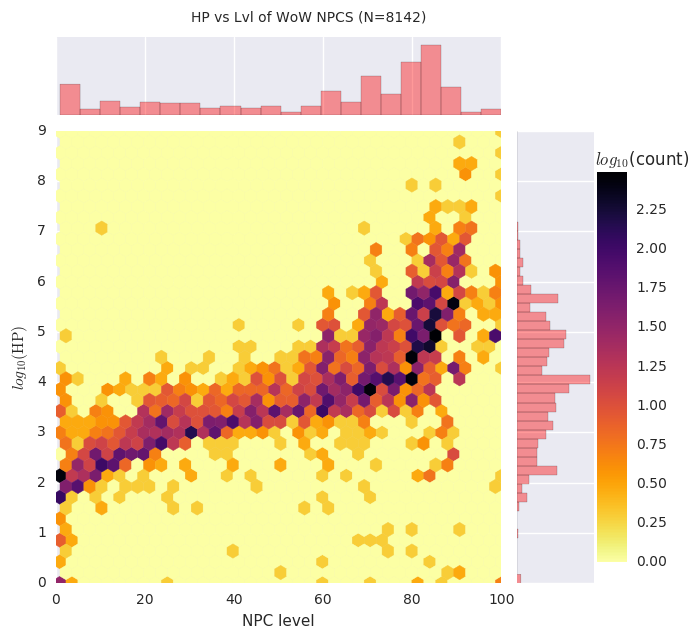

In [101]:
ax = sns.jointplot(lvls, hps, stat_func=None, kind='hex', 
                    xlim=(0, LEVEL_CUTOFF), bins='log', color='r', cmap='inferno_r'
                    )
ax.fig.suptitle('HP vs Lvl of WoW NPCS (N={N})'.format(N=lvls.size), y=1.02)
ax.ax_joint.set_xlabel('NPC level')
ax.ax_joint.set_ylabel(r'$log_{10}(\mathrm{HP})$')
cax = ax.fig.add_axes([0.98, 0.1, 0.05, 0.65])
plt.colorbar(cax=cax)
cax.set_title('$log_{10}$(count)', x=1.5)

## Lessons learned from visualizing the data

* Overall, HP pools increase roughly exponentially with NPC level, with a sharp uptick near the current maximum level.
* There are well-defined peaks in the number of NPCs at levels 60, 70, and 80, the points of historical maximum levels for player characters. This suggests that the developers focus their efforts on offering a variety of "end-game" content, which is anecdotally true.

## Open questions

* What's going on with the pockets of low-HP high-level NPCs? Are these "punching bag" NPCs for assessing DPS?
* How does the introduction of "difficulty" in raids affect this? It's very likely that the scraping process is hampered by this, because we just grab the very first thing that looks like an HP. But there are plenty of pages with *multiple* HP values!